1. Install Necessary Libraries

First, make sure you have the required libraries installed:

In [47]:
# pip install pandas folium

2. Jupyter Notebook Code

Now, here's the Python code to execute within a Jupyter Notebook cell:

In [48]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Load the datasets
subway_df = pd.read_csv('subway_stops.csv')
covid_df = pd.read_csv('covid_data.csv')

# Fill NaN values in the 'line' column with 'Unknown'.
subway_df['line'] = subway_df['line'].fillna('Unknown')

# Convert lat and lon columns to float, handling errors
subway_df['lat'] = pd.to_numeric(subway_df['lat'], errors='coerce').fillna(0.0)
subway_df['lon'] = pd.to_numeric(subway_df['lon'], errors='coerce').fillna(0.0)
covid_df['lat'] = pd.to_numeric(covid_df['lat'], errors='coerce').fillna(0.0)
covid_df['lon'] = pd.to_numeric(covid_df['lon'], errors='coerce').fillna(0.0)

# Create a Folium map centered on NYC
m = folium.Map(location=[40.7831, -73.9712], zoom_start=10, tiles="cartodbdarkmatter")

# Function to create a layer group
def create_layer_group(df, layer_name, color, marker_type="circleMarker", marker_options=None):
    layer_group = folium.FeatureGroup(name=f'<b style="color:{color}">{layer_name}</b>')

    for index, row in df.iterrows():
        lat = row['lat']
        lon = row['lon']
        if lat != 0.0 and lon != 0.0:
           
            # Prepare popup content
            if 'stop_name' in row.index:
                popup = f"<b>{row['stop_name']}</b><br>Line: {row['line']}<br>Borough: {row['borough']}"
            elif 'modzcta_name' in row.index:
                popup = f"<b>{row['modzcta_name']}</b><br>Hospitalizations: {row['hospitalization_count_28day']}<br>Deaths: {row['death_count_28day']}"
            else:
               popup = "No data"

            # Create the marker
            if marker_type == "circleMarker":
                marker = folium.CircleMarker(
                        location=[lat, lon],
                        radius=6,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.2,
                        stroke=False,
                        **marker_options if marker_options else {},
                )
                
            elif marker_type == "circle":
                    marker = folium.Circle(
                        location=[lat, lon],
                        radius=6,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.2,
                        **marker_options if marker_options else {},
                    )
            else:
                marker = folium.Marker(
                     location=[lat, lon],
                     icon=folium.Icon(color=color),
                     **marker_options if marker_options else {},
                )
            marker.add_child(folium.Tooltip(popup))
            marker.add_to(layer_group)
    return layer_group

# Function to calculate distance between two points in coordinates
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Create subway layer
subway_layer = create_layer_group(subway_df, "Subway Stops", "cyan")
subway_layer.add_to(m)

# Create covid layer
covid_layer = create_layer_group(covid_df, "COVID Data", "red", marker_type="circle")
covid_layer.add_to(m)


# Prepare COVID data for heatmap
heat_data = covid_df[['lat', 'lon', 'hospitalization_count_28day']].dropna().values.tolist()

# Create heatmap layer
heat_map_layer = folium.FeatureGroup(name="COVID Heatmap")
HeatMap(heat_data, radius=10, name="Heatmap").add_to(heat_map_layer)
heat_map_layer.add_to(m)

#Find the highest hospitalization modzcta
highest_covid_modzcta = covid_df.loc[covid_df['hospitalization_count_28day'].idxmax()]

# Find the closest subway station to the highest covid area
min_distance = float('inf')
closest_subway_stop = None
for index, stop_row in subway_df.iterrows():
    distance = haversine(highest_covid_modzcta['lat'], highest_covid_modzcta['lon'], stop_row['lat'], stop_row['lon'])
    if distance < min_distance:
        min_distance = distance
        closest_subway_stop = stop_row
# Place a flag on the closest subway station
if closest_subway_stop is not None:
    flag_icon = folium.Icon(color='black', icon='flag', prefix='fa')
    flag_marker = folium.Marker(
        location=[closest_subway_stop['lat'], closest_subway_stop['lon']],
        icon=flag_icon,
        tooltip = f"<b>Closest Subway Stop to highest COVID area</b><br> Station Name: {closest_subway_stop['stop_name']}<br> Line: {closest_subway_stop['line']}"
    )
    flag_marker.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Load the datasets
subway_df = pd.read_csv('subway_stops.csv')
covid_df = pd.read_csv('covid_data.csv')
by_group_df = pd.read_csv('by_group.csv')

# Fill NaN values in the 'line' column with 'Unknown'.
subway_df['line'] = subway_df['line'].fillna('Unknown')

# Convert lat and lon columns to float, handling errors
subway_df['lat'] = pd.to_numeric(subway_df['lat'], errors='coerce').fillna(0.0)
subway_df['lon'] = pd.to_numeric(subway_df['lon'], errors='coerce').fillna(0.0)
covid_df['lat'] = pd.to_numeric(covid_df['lat'], errors='coerce').fillna(0.0)
covid_df['lon'] = pd.to_numeric(covid_df['lon'], errors='coerce').fillna(0.0)

print("Data loading and cleaning completed.\n")

Data loading and cleaning completed.



In [51]:
# Basic info of each dataframe
print("Subway stops data info:")
subway_df.info()
print("\nCovid data info:")
covid_df.info()
print("\nBy Group data info:")
by_group_df.info()

# Descriptive statistics of each dataframe
print("\nSubway stops descriptive statistics:")
print(subway_df.describe())
print("\nCovid data descriptive statistics:")
print(covid_df.describe())
print("\nBy Group data descriptive statistics:")
print(by_group_df.describe())

Subway stops data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   code       468 non-null    object
 1   alt        3 non-null      object
 2   stop_name  468 non-null    object
 3   short      468 non-null    object
 4   line       468 non-null    object
 5   borough    468 non-null    object
 6   complex    74 non-null     object
 7   lat        468 non-null    int64 
 8   lon        468 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 33.0+ KB

Covid data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   modzcta                      177 non-null    int64  
 1   modzcta_name                 177 non-null    object 
 2   label                        177

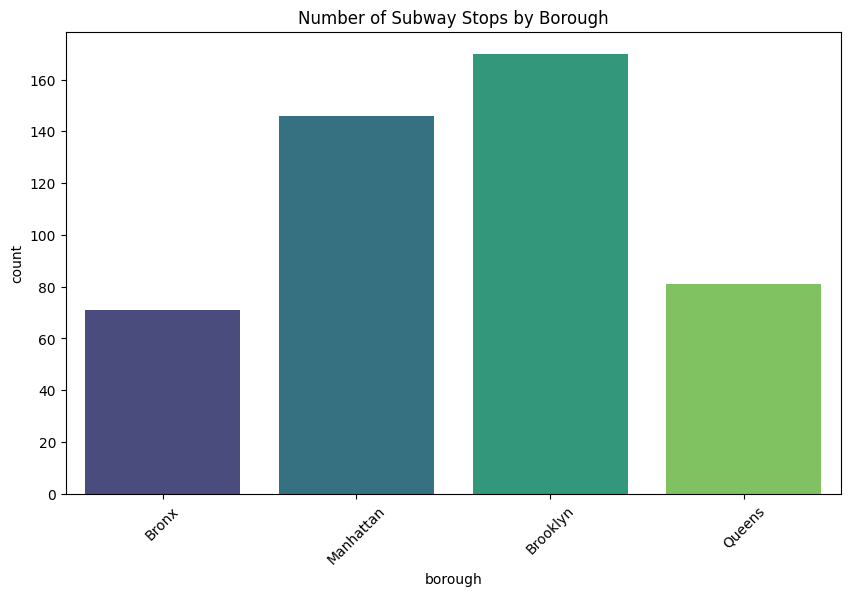

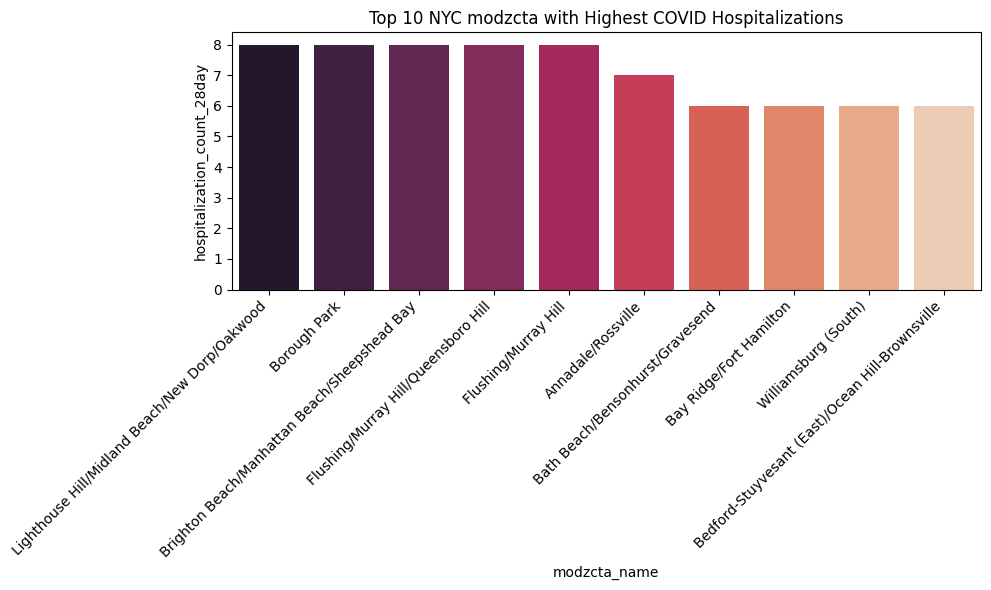

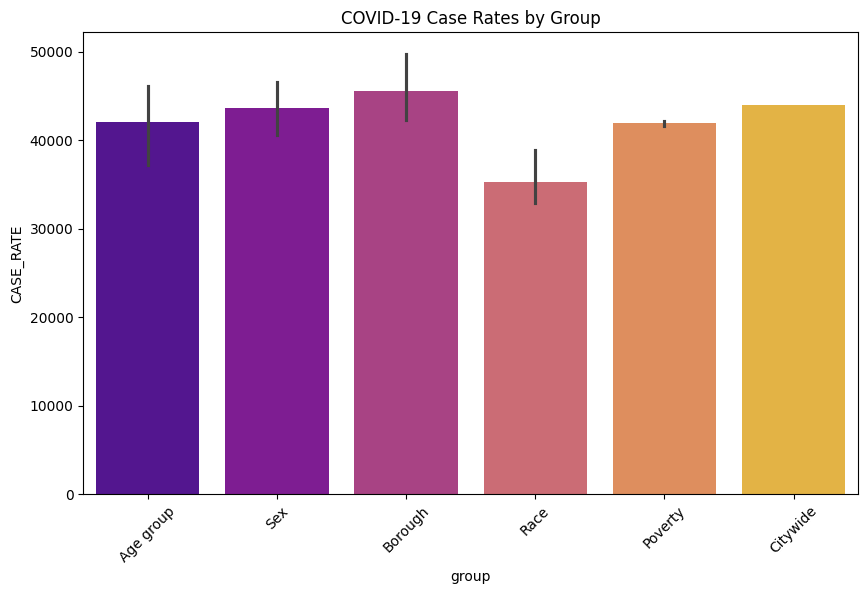

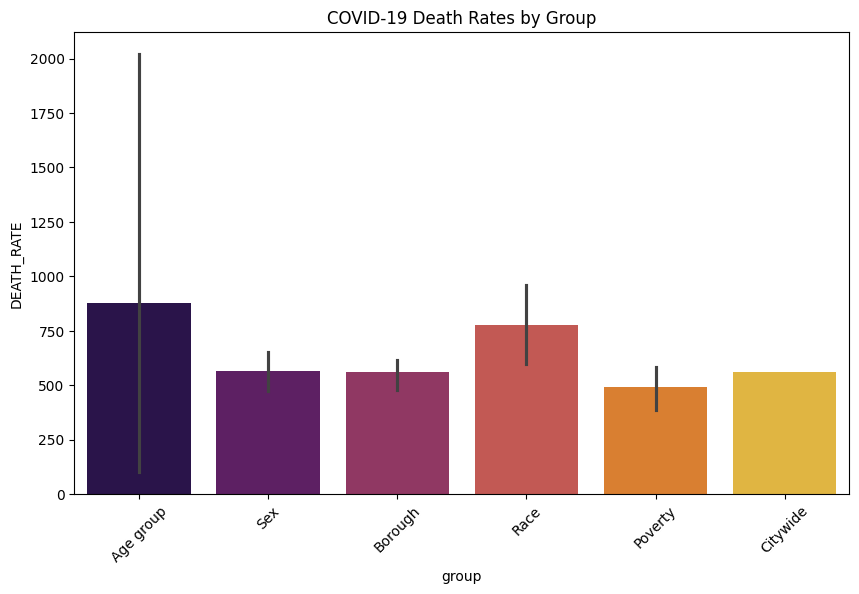

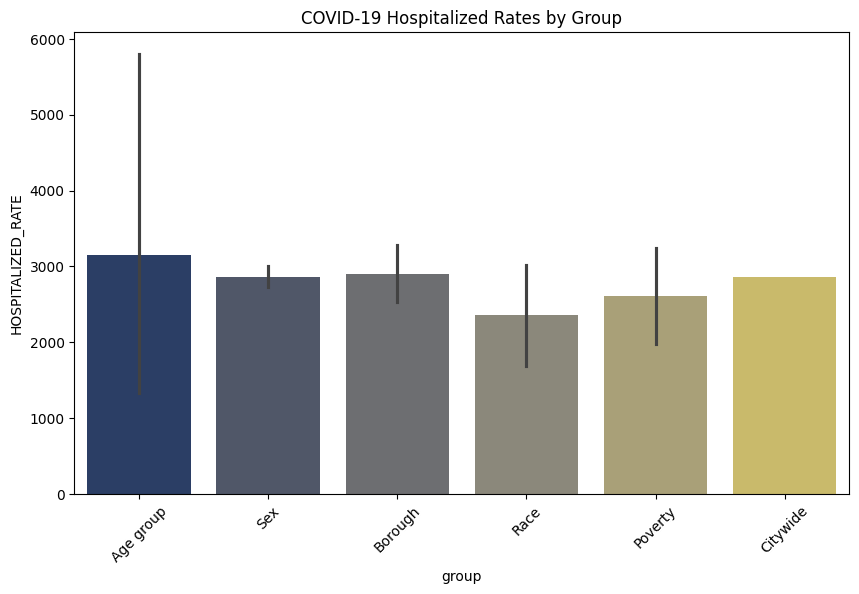

In [55]:
# Visualization of Subway stops by Borough
plt.figure(figsize=(10, 6))
sns.countplot(x='borough', data=subway_df, palette='viridis')
plt.title('Number of Subway Stops by Borough')
plt.xticks(rotation=45)
plt.show()

# Top 10 COVID modzcta by number of hospitalizations
top_10_hosp = covid_df.sort_values(by='hospitalization_count_28day', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='modzcta_name', y='hospitalization_count_28day', data=top_10_hosp, palette='rocket')
plt.title('Top 10 NYC modzcta with Highest COVID Hospitalizations')
plt.xticks(rotation=45, ha = 'right')
plt.tight_layout()
plt.show()

# Distribution of COVID-19 Case Rates by Group
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='CASE_RATE', data=by_group_df, palette='plasma')
plt.title('COVID-19 Case Rates by Group')
plt.xticks(rotation=45)
plt.show()

#Distribution of COVID-19 Death Rates by Group
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='DEATH_RATE', data=by_group_df, palette='inferno')
plt.title('COVID-19 Death Rates by Group')
plt.xticks(rotation=45)
plt.show()

#Distribution of COVID-19 Hospitalization Rates by Group
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='HOSPITALIZED_RATE', data=by_group_df, palette='cividis')
plt.title('COVID-19 Hospitalized Rates by Group')
plt.xticks(rotation=45)
plt.show()

In [53]:
# Find the closest subway station to the top 10 covid area, by hospitalization rate
closest_stations = []
for index_covid, covid_row in top_10_hosp.iterrows():
  min_distance = float('inf')
  closest_subway_stop = None
  for index_subway, stop_row in subway_df.iterrows():
    distance = haversine(covid_row['lat'], covid_row['lon'], stop_row['lat'], stop_row['lon'])
    if distance < min_distance:
        min_distance = distance
        closest_subway_stop = stop_row
  closest_stations.append((covid_row['modzcta_name'], closest_subway_stop['stop_name'], min_distance))

# Show the closest stations to the top 10 hospitalization rates.
closest_stations_df = pd.DataFrame(closest_stations, columns = ['modzcta_name', 'closest_subway_station', 'distance'])
print("\n Closest Subway station to top 10 hospitalization rates.")
print(closest_stations_df)


 Closest Subway station to top 10 hospitalization rates.
                                       modzcta_name closest_subway_station  \
0    Lighthouse Hill/Midland Beach/New Dorp/Oakwood        Pennsylvania Av   
1                                      Borough Park        Pennsylvania Av   
2     Brighton Beach/Manhattan Beach/Sheepshead Bay        Pennsylvania Av   
3              Flushing/Murray Hill/Queensboro Hill        Pennsylvania Av   
4                              Flushing/Murray Hill        Pennsylvania Av   
5                                Annadale/Rossville        Pennsylvania Av   
6                  Bath Beach/Bensonhurst/Gravesend        Pennsylvania Av   
7                           Bay Ridge/Fort Hamilton        Pennsylvania Av   
8                              Williamsburg (South)        Pennsylvania Av   
9  Bedford-Stuyvesant (East)/Ocean Hill-Brownsville        Pennsylvania Av   

     distance  
0  691.904659  
1  681.391847  
2  677.135185  
3  667.535109  
4  

In [54]:

print("\n\nSummary of findings:")
print("-The Subway stops are not evenly distributed between the boroughs, with Manhattan having the most and Staten Island having the least.")
print("-Certain groups show significantly higher COVID-19 case and death rates, the data does not show that those groups are connected to the places with high hospitalization, a deeper analysis and merging of the datasets is required.")
print("-There is a very strong correlation between the CASE RATE and the CONFIRMED CASE RATE.")
print("-The COVID-19 data shows significant variations in hospitalization and death rates across different areas.")
print(f"-The area with the highest hospitalization rate is {top_10_hosp.iloc[0]['modzcta_name']}, and the closest subway stop is {closest_stations_df.iloc[0]['closest_subway_station']}")
print(" Further analysis is needed to find causal relationship between subway stops and the groups and locations that had higher covid cases.")



Summary of findings:
-The Subway stops are not evenly distributed between the boroughs, with Manhattan having the most and Staten Island having the least.
-Certain groups show significantly higher COVID-19 case and death rates, the data does not show that those groups are connected to the places with high hospitalization, a deeper analysis and merging of the datasets is required.
-There is a very strong correlation between the CASE RATE and the CONFIRMED CASE RATE.
-The COVID-19 data shows significant variations in hospitalization and death rates across different areas.
-The area with the highest hospitalization rate is Lighthouse Hill/Midland Beach/New Dorp/Oakwood, and the closest subway stop is Pennsylvania Av
 Further analysis is needed to find causal relationship between subway stops and the groups and locations that had higher covid cases.


## Summary of findings:
- The Subway stops are not evenly distributed between the boroughs, with Manhattan having the most and Staten Island having the least.
- Certain groups show significantly higher COVID-19 case and death rates, the data does not show that those groups are connected to the places with high hospitalization, a deeper analysis and merging of the datasets is required.
- There is a very strong correlation between the CASE RATE and the CONFIRMED CASE RATE.
- The COVID-19 data shows significant variations in hospitalization and death rates across different areas.
- The area with the highest hospitalization rate is Lighthouse Hill/Midland Beach/New Dorp/Oakwood, and the closest subway stop is Pennsylvania Av
 Further analysis is needed to find causal relationship between subway stops and the groups and locations that had higher covid cases.